# Classificação de litofácies usando aprendizado de maquina e o auxílio de um algoritmo de detecção de camadas

O conjunto de dados que usaremos vem de um exercício de classe da Universidade de Kansas nos campos de gás Hugoton e Panoma. Para maior informação do origem dos dados ver Dubois et al. (2007).

O código esta baseado no repositorio da [SEG](https://github.com/seg/tutorials-2016/tree/master/1610_Facies_classification).

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem: Computers & Geosciences, 33, no. 5, 599–617, https://doi.org/10.1016/j.cageo.2006.08.011


Esse trabalho utiliza como base o colab do professor Pedro Diaz, disponível em https://github.com/ICA-cursos/bi-master_machine-learning/tree/master/Classifica%C3%A7%C3%A3o/Estudo%20de%20caso%20de%20classifica%C3%A7%C3%A3o%20de%20facies%20sismicas.
Vamos implementar um algoritmo conhecido de detecção de camadas (from scratch) baseado no artigo clássico de Reid, "*Automatic bedding discriminator for use with digital wireline logs*", de 1989. Utilizamos o resultado da aplicação como atributos de entrada em dois classificadores de inteligência artificial, SVM e Random Forest, e observamos o impacto desses atributos nos resultado. De acordo com o levantamento bilbiográfico feito, ainda não exisrtem registros da combinação dessas técnicas para classificar litofácies em poços de petróleo.
Utilizamos o artigo "*Automatic Lithofacies Classification with t-SNE and K-Nearest Neighbors Algorithm*" (Potratz et al,2021) como referência para avaliar a qualidade dos resultados obtidos utilizando o mesmo método de validação (holdout simples 70/30) e métricas de avaliação (F-1 Score, Precision e Recall).


## 1. Montar o Drive

Executando as seguintes linhas de codigo, podemos montar nosso Google Drive no Colab:

```python
from google.colab import drive
drive.mount('/content/drive')
```


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/Monografia

/content/drive/My Drive/Monografia


## 2. Carregando os dados

In [1]:
# Carregando as bibliotecas necessarias
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Leitura do conjunto de dados
dataset_filename = 'facies_vectors.csv'
training_data = pd.read_csv(dataset_filename) # carregar o arquivo csv
# Conversão das colunas "Well Name" e "Formation" para o tipo categorical
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


## 3. Análise de dados

### 3.1. Explorando os dados

Temos 10 poços com os seguintes nomes:

In [3]:
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN',
                          'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

Os 7 atributos disponíveis no conjunto de dados são os seguintes:
* [Gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR)
* [Resistivity](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10)
* [Photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE)
* [Neutron-density porosity difference](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI)
* Average neutron-density porosity (PHIND)
* Nonmarine/marine indicator (NM_M)
* Relative position (RELPOS)

A tabela a seguir lista as fácies, seus labels abreviados e suas fàcies adjacentes.

Fácies | Descrição | Label| Fácies adjacentes
:---: | :---: | :---: | :--:
1 | Nonmarine sandstone | SS | 2
2 | Nonmarine coarse siltstone | CSiS | 1,3
3 | Nonmarine fine siltstone | FSiS| 2
4 | Marine siltstone and shale | SiSh| 5
5 | Mudstone (limestone) | MS | 4,6
6 | Wackestone (limestone) | WS | 5,7
7 | Dolomite | D | 6,8
8 | Packstone-grainstone (limestone) | PS | 6,7,9
9 | Phylloid-algal bafflestone (limestone) | BS | 7,8

Vamos definir um mapa de cores para representar as fácies

In [4]:
facies_color_map = {'SS': '#F4D03F',
                    'CSiS': '#F5B041',
                    'FSiS': '#DC7633',
                    'SiSh': '#6E2C00',
                    'MS': '#1B4F72',
                    'WS': '#2E86C1',
                    'D': '#AED6F1',
                    'PS': '#A569BD',
                    'BS': '#196F3D'}
facies_labels = list(facies_color_map.keys())

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


Visão rápida da distribuição estatística dos atributos. Olhando para os valores `count`, a maioria dos valores tem 4149 valores válidos, exceto para` PE`, que tem 3232. Vamos a remover os dados que não tem um valor `PE` válido.

In [ ]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [5]:
training_data['PE']

0       4.600
1       4.100
2       3.600
3       3.500
4       3.400
        ...  
4144    3.617
4145    3.344
4146    3.190
4147    3.152
4148    3.295
Name: PE, Length: 4149, dtype: float64

In [6]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


### 3.2. Visualização dos Poços

Função para visualizar o poço e seus atributos

In [7]:
def make_facies_log_plot(logs, facies_colors):
    # Ordenar os valores por profundidade
    logs = logs.sort_values(by='Depth')
    # Mapa de cores
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    # Dicionário com atributos e cor para cada atributo
    feat_dict = {"GR":"green",
                 "ILD_log10":"blue",
                 "DeltaPHI":"magenta",
                 "PHIND":"red",
                 "PE":"black"}
    n_feats = len(feat_dict)
    # Profundidade mínima e máxima
    ztop=logs.Depth.min()
    zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 12))    
    for i, key in enumerate(feat_dict):
        ax[i].plot(logs[key], logs.Depth, '-', color=feat_dict[key])
    im=ax[n_feats].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1))
    cbar.set_ticklabels('')

    for i, key in enumerate(feat_dict):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)        
        ax[i].set_xlabel(key)
        ax[i].set_xlim(logs[key].min(),logs[key].max())
        if i>0:
            ax[i].set_yticklabels([])

    ax[n_feats].set_xlabel('Fácies')    
    ax[n_feats].set_yticklabels([])
    ax[n_feats].set_xticklabels([])
    
    f.suptitle('Poço: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

 

Colocar o código da plotagem dos perfis em uma função torna mais fácil a apresentação dos perfis de múltiplos poços, e pode ser reusado mais tarde para visualizar os resultados quando aplicamos o modelo de classificação de fácies em outros poços. A função foi escrita para receber a lista de cores e os rótulos das fácies como parâmetros.

Para exemplificar plotaremos os perfis dos poços `SHRIMPLIN`, `SHANKLE` e 'NEWBY'.
 

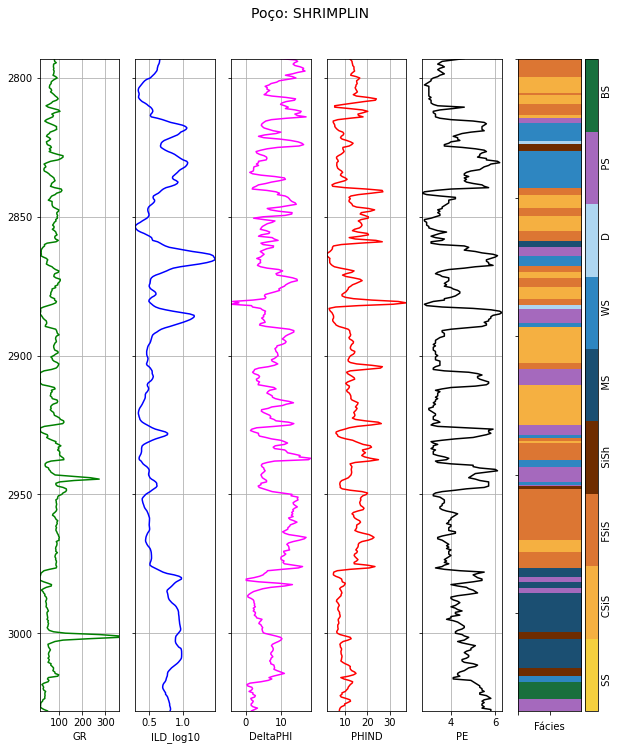

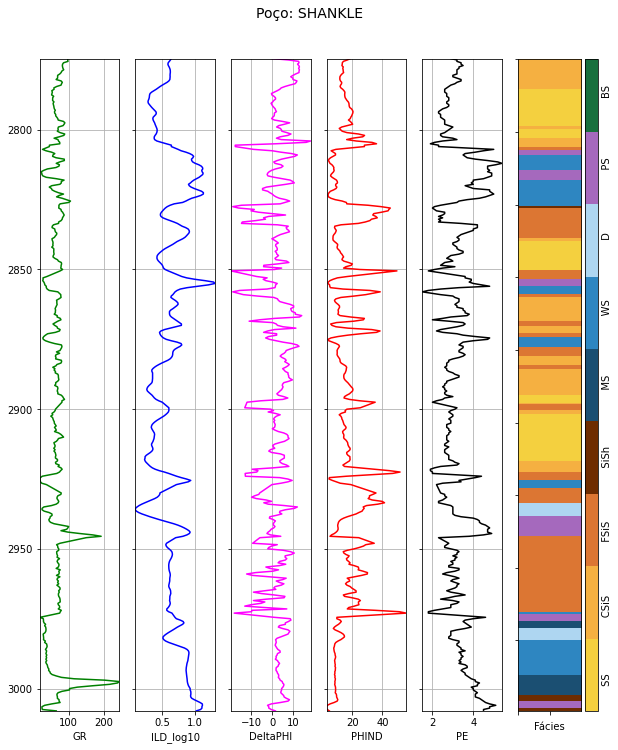

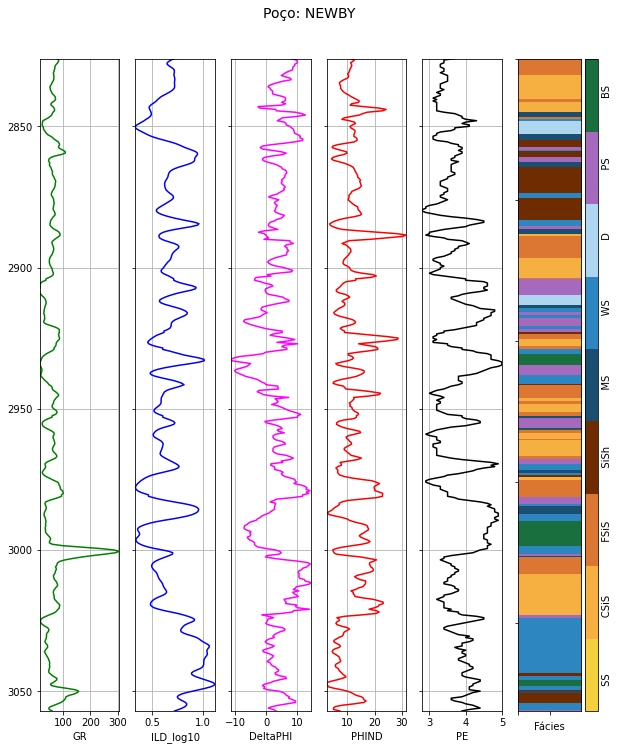

In [8]:
facies_colors = list(facies_color_map.values())

well_log = training_data[training_data['Well Name'] == 'SHRIMPLIN']
make_facies_log_plot(well_log, facies_colors)

well_log = training_data[training_data['Well Name'] == 'SHANKLE']
make_facies_log_plot(well_log, facies_colors)

well_log = training_data[training_data['Well Name'] == 'NEWBY']
make_facies_log_plot(well_log, facies_colors)

### 3.3. Distribuição dos dados

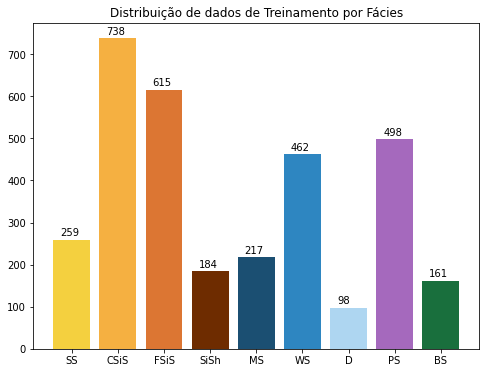

In [9]:
# Numero de amostras por classe
_, facies_counts = np.unique(training_data['Facies'].values, return_counts=True)
facies_colors = list(facies_color_map.values())

plt.figure(figsize=(8,6))
plt.bar(facies_labels, facies_counts, color=facies_colors)
plt.title("Distribuição de dados de Treinamento por Fácies")
xlocs,_ = plt.xticks()
for i, v in enumerate(facies_counts):
    plt.text(xlocs[i] - 0.25, v + 10, str(v))
plt.show()

Como podemos observar nesse gráfico de barras, a base é desbalanceada. Tomaremos o cuidado de garantir que os conjuntos de treino e teste mantenham a mesma proporção de litofácies.

### 3.4. Boxplot
Apresentamos o boxplot das propriedades por fácies de todo o conjunto de dados e de um poço, como exemplo. O boxplot mostra a sobreposição entre as medidas das propriedades para cada uma das fácies.

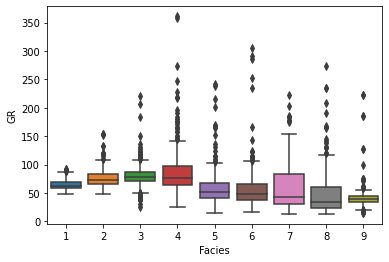

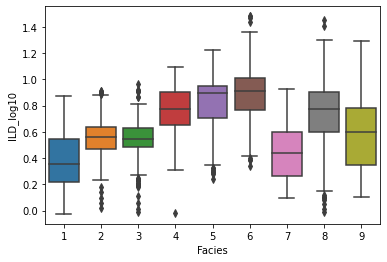

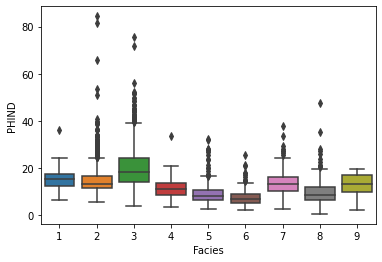

In [10]:
import seaborn as sns
well_log = training_data
sns.boxplot(x=well_log['Facies'], y=well_log['GR'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['ILD_log10'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['PHIND'])
plt.show()

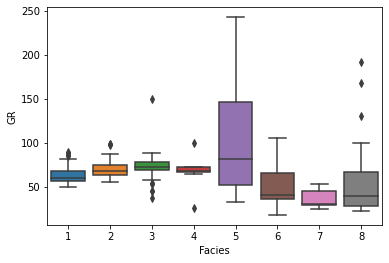

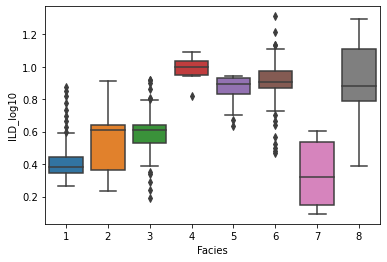

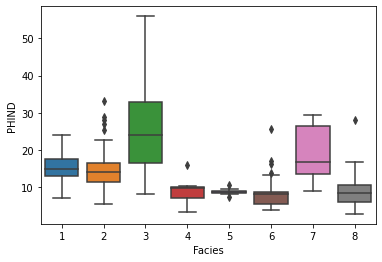

In [11]:
well_log = training_data[training_data['Well Name'] == 'SHANKLE']
sns.boxplot(x=well_log['Facies'], y=well_log['GR'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['ILD_log10'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['PHIND'])
plt.show()

### 3.5. Analise dos Atributos

Pairplot dos atributos

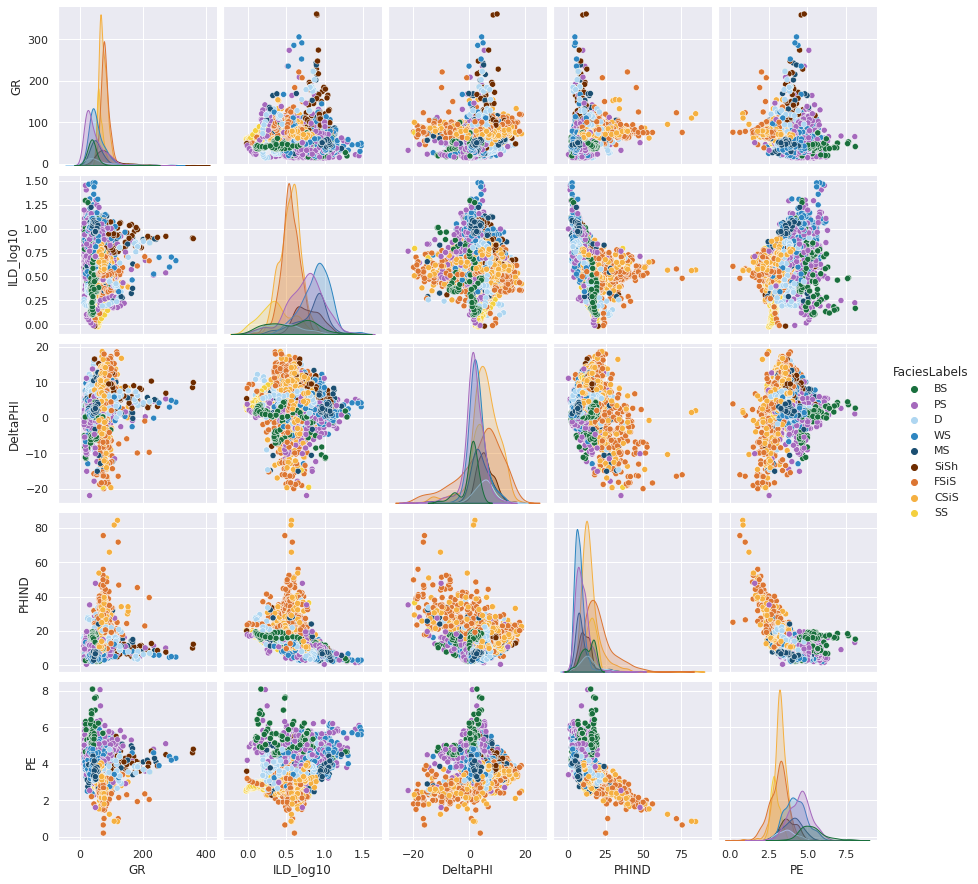

In [ ]:
import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
sns.reset_orig()

## 4. Support Vector Machine - SVM

### 4.1. Conjunto de dados

In [12]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


**Normalização**

Os atributos estão em diferentes faixas de valores, devido a isso, é necessario normalizar os atributos.
Vamos usar a normalização padrão:

$$z = {(x - \mu) \over \sigma}$$

onde:

$\mu$ é a média, e $\sigma$ é o desvio padrão

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)
pd.DataFrame(scaled_features).describe()

,0,1,2,3,4,5,6
count,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03
mean,2.941816e-16,4.854478e-16,-4.356560e-17,-9.195752e-17,6.832406e-16,1.556511e-15,5.989090e-17
std,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00
min,-1.714285e+00,-2.765296e+00,-4.856726e+00,-1.680121e+00,-3.934108e+00,-9.969107e-01,-1.779569e+00
25%,-6.229169e-01,-6.202015e-01,-4.582685e-01,-6.672647e-01,-6.975496e-01,-9.969107e-01,-8.623869e-01
50%,-1.342848e-02,-7.560721e-02,-1.140783e-02,-1.731943e-01,-1.936510e-01,-9.969107e-01,1.992191e-02
75%,4.372920e-01,7.031033e-01,5.494992e-01,3.858948e-01,6.417158e-01,1.003099e+00,8.612539e-01
max,9.562844e+00,3.462598e+00,2.876809e+00,9.212618e+00,4.876027e+00,1.003099e+00,1.672943e+00


Divisão do conjunto de dados em conjunto de treinamento e teste:

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.33, random_state=42)

print("Conjunto de dados: \t\tX: {}, \t\tY:{}".format(scaled_features.shape, correct_facies_labels.shape))
print("Conjunto de Treinamento: \tX_train: {}, \tY_train:{}".format(X_train.shape, y_train.shape))
print("Conjunto de Teste: \t\tX_test: {}, \tY_test:{}".format(X_test.shape, y_test.shape))

Conjunto de dados: 		X: (3232, 7), 		Y:(3232,)
Conjunto de Treinamento: 	X_train: (2165, 7), 	Y_train:(2165,)
Conjunto de Teste: 		X_test: (1067, 7), 	Y_test:(1067,)


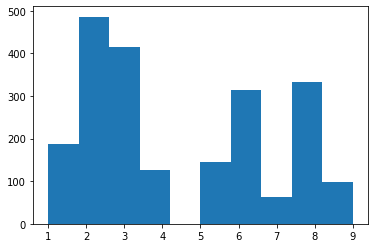

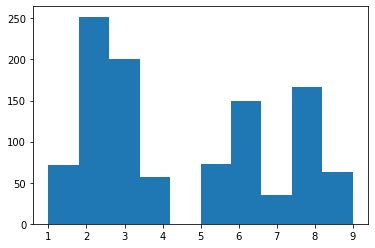

In [15]:
plt.hist(y_train)
plt.show()
plt.hist(y_test)
plt.show()

### 4.2. Treinamento do classificador SVM

In [85]:
from sklearn import svm
# Classificador SVM
clf_SVM = svm.SVC()
# Treinamento
clf_SVM.fit(X_train,y_train)
# Predição nos conjunto de teste
predicted_labels_SVM = clf_SVM.predict(X_test)

Avaliação da predição

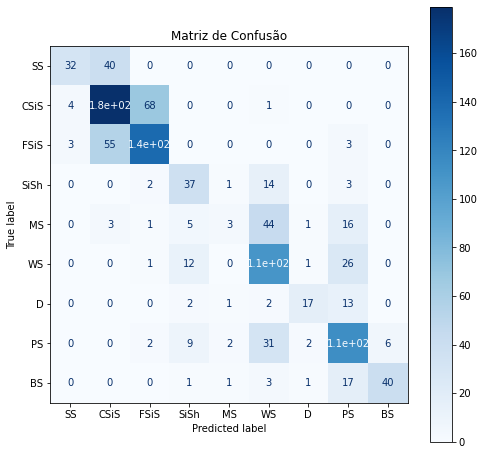

In [86]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

conf_SVM = confusion_matrix(y_test, predicted_labels_SVM)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_SVM, X_test, y_test, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, 
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [87]:
report = classification_report(y_true=y_test,y_pred=predicted_labels_SVM)
print(report)

              precision    recall  f1-score   support

           1       0.82      0.44      0.58        72
           2       0.65      0.71      0.68       252
           3       0.65      0.69      0.67       200
           4       0.56      0.65      0.60        57
           5       0.38      0.04      0.07        73
           6       0.53      0.73      0.62       149
           7       0.77      0.49      0.60        35
           8       0.59      0.69      0.64       166
           9       0.87      0.63      0.73        63

    accuracy                           0.63      1067
   macro avg       0.65      0.56      0.58      1067
weighted avg       0.63      0.63      0.61      1067



Métricas de avaliação

In [88]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

`adjacent_facies[i]` é um array com as fácies adjacentes.

In [89]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

Facies classification accuracy = 0.6279287722586692
Adjacent facies classification accuracy = 0.9240862230552952


In [90]:
# acrescentando outras métricas
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
print('F1-score = {}'.format(f1_score(y_test , predicted_labels_SVM, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_test , predicted_labels_SVM)))

F1-score = 0.610339584402228
MCC = 0.5586459226358361


### 4.3 Aplicando o detector de camadas a partir do gamma ray

Agora, definimos uma metodologia para tentar melhorar os resultados do classificador. Baseado na ideia de que podemos aumentar a acurácia na classificação de litofácies separando os dados em segmentos correspondentes a seções homogêneas de rocha. Também partiremos da hipótese que essas seções de rocha podem ser detectadas por uma mudança súbita em um valor do perfil e que cada litologia tem uma assinatura de perfil distinta.
Reid (1989) descreveu uma abordagem que ele chamou de *Automatic Bedding Discriminator*, em que através das interseções entre as filtragens por média móvel com diferentes janelas é determinada a passagem de uma camada para outra.
A importância de aplicar essa técnica se dá pelo fato de que uma grande variedade de variáveis tais como diâmetro do furo, desmoronamento da formação e lama de perfuração são detectadas pelas ferramentas de aquisição de perfis geofísicos de poços. Essas mudanças não tem significado geológico e devem ser desconsideradas na análise. Uma primeira aplicação da média móvel, com uma janela pequena (Reid sugere 1 ou 2m), dá conta de eliminar boa parte do ruído, em seguida uma nova média móvel é aplicada, com uma janela bem maior que a anterior, mostrando a tendência geral do perfil (Reid sugere uma janela de 10m, no nosso caso 20 amostras, já que as medidas foram feitas de 50 em 50 cm). Comparando os dois logs filtrados, os pontos onde ocorrem uma mudança brusca serão determinados ao se checar em quais posições eles se interceptam, ou seja, onde o perfil cresce ou decresce mais que sua tendência geral.




In [91]:
#Aplicar o detetor de camadas antes da normalização. Primeiro passo é criar uma função para as médias móveis
def mediamovel(GR,janela):
    log_suave = GR.rolling(window= janela).mean()
    log_suave[0:(janela-1)]=GR[0:(janela-1)]
    return log_suave




In [92]:
# Função para determinar as camadas baseado nas interseções e aplicar as médias dos perfis
from statistics import mean
def camadas(mediapequena,mediagrande, GR, PHI, ILD, DPHI, PE ):
    teste = mediapequena - mediagrande
    GR_disc = [GR]
    PHI_disc = [PHI]
    ILD_disc = [ILD]
    DPHI_disc = [DPHI]
    PE_disc = [PE]
    n= len(teste)-1
    k=0
    for i in range(0,n):
       if teste[i]*teste[i+1] < 0: 
           GR_disc[k:(i+1)] = [mean(GR[k:(i+1)])]*(i+1-k)  
           PHI_disc[k:(i+1)] = [mean(PHI[k:(i+1)])]*(i+1-k)
           ILD_disc[k:(i+1)] = [mean(ILD[k:(i+1)])]*(i+1-k)
           DPHI_disc[k:(i+1)] = [mean(DPHI[k:(i+1)])]*(i+1-k)
           PE_disc[k:(i+1)] = [mean(PE[k:(i+1)])]*(i+1-k)
           k = i+1
     
  
    if k<(n+1) :
       GR_disc[k:(n+1)] = [mean(GR[k:(n+1)])]*(n+1-k) 
       PHI_disc[k:(n+1)] = [mean(PHI[k:(n+1)])]*(n+1-k) 
       ILD_disc[k:(n+1)] = [mean(ILD[k:(n+1)])]*(n+1-k) 
       DPHI_disc[k:(n+1)] = [mean(DPHI[k:(n+1)])]*(n+1-k) 
       PE_disc[k:(n+1)] = [mean(PE[k:(n+1)])]*(n+1-k) 
  
    return [GR_disc, PHI_disc, ILD_disc,  DPHI_disc, PE_disc  ]

     


#### Aplicando o algoritmo de detecção de camadas em toda a base de treinamento

In [93]:
new_training_data = training_data.copy()
list_wells = new_training_data['Well Name'].unique().tolist()
GR_preproc = []
PHI_preproc = []
ILD_preproc = []
DPHI_preproc = []
PE_preproc = []
for poco in list_wells:
    well_log = new_training_data[new_training_data['Well Name'] == poco].copy()
    well_log.reset_index(inplace=True)
    GR = well_log['GR']
    ILD = well_log['ILD_log10']
    PHI = well_log['PHIND']
    PE = well_log['PE']
    DPHI = well_log['DeltaPHI']
    # Aplicando os filtros de média móvel
    mediapequena= mediamovel(GR,2)
    mediagrande = mediamovel(GR,16) # nossos testes mostraram que o melhor parâmetro aqui é 16. Sugestão testar entre 14 e 24 em outras bases
    # Gerando os perfis processados
    preproc_logs = camadas(mediapequena,mediagrande, GR, PHI, ILD, DPHI, PE)
    GR_preproc.extend(preproc_logs[0])
    PHI_preproc.extend(preproc_logs[1])
    ILD_preproc.extend(preproc_logs[2])
    DPHI_preproc.extend(preproc_logs[3])
    PE_preproc.extend(preproc_logs[4])
    


In [94]:
# Trocando as colunas pelos perfis processados
new_training_data['GR'] = GR_preproc
new_training_data['ILD_log10'] = ILD_preproc
new_training_data['PHIND'] = PHI_preproc
new_training_data['DeltaPHI'] = DPHI_preproc
new_training_data['PE'] = PE_preproc




 Comparando as estatísticas dos perfis antes e depois do pré-processamento vemos que mantendo as médias, reduzimos a variância e eliminamos os dados extremos.

In [95]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [96]:
new_training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,24.095484,0.220666,3.976911,6.050616,0.762029,0.500075,0.286792
min,1.000000,2573.500000,19.892308,-0.022562,-13.066667,2.700000,1.466167,1.000000,0.010000
25%,2.000000,2791.000000,49.996250,0.496700,1.210579,9.362500,3.195196,1.000000,0.273000
50%,4.000000,2893.500000,68.845421,0.635950,3.223077,12.400000,3.581801,1.000000,0.526000
75%,6.000000,2980.000000,79.460842,0.798308,5.523485,16.306250,4.194000,2.000000,0.767250
max,9.000000,3122.500000,199.246250,1.283500,16.900000,61.475000,6.393556,2.000000,1.000000


Visualizando 


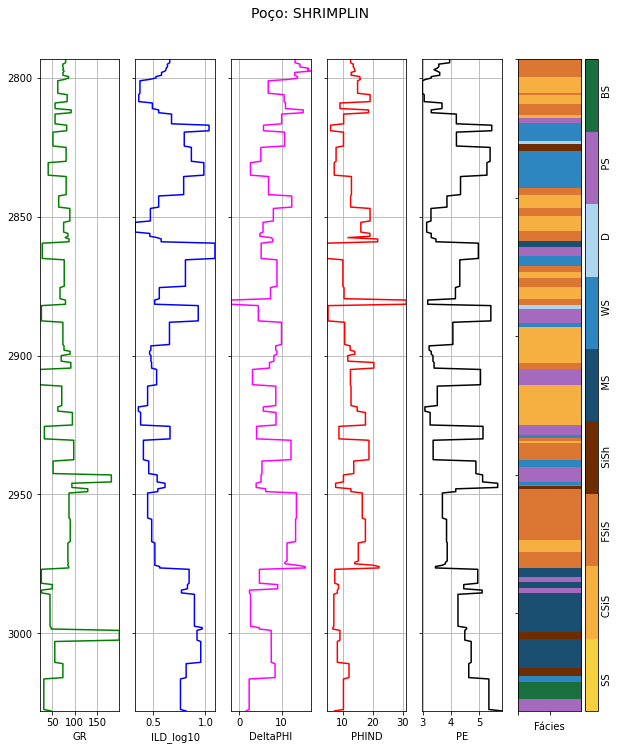

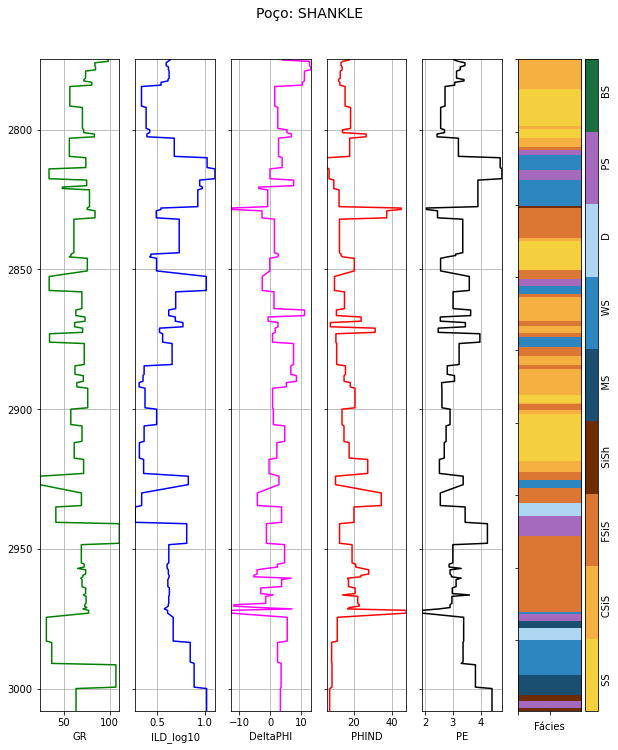

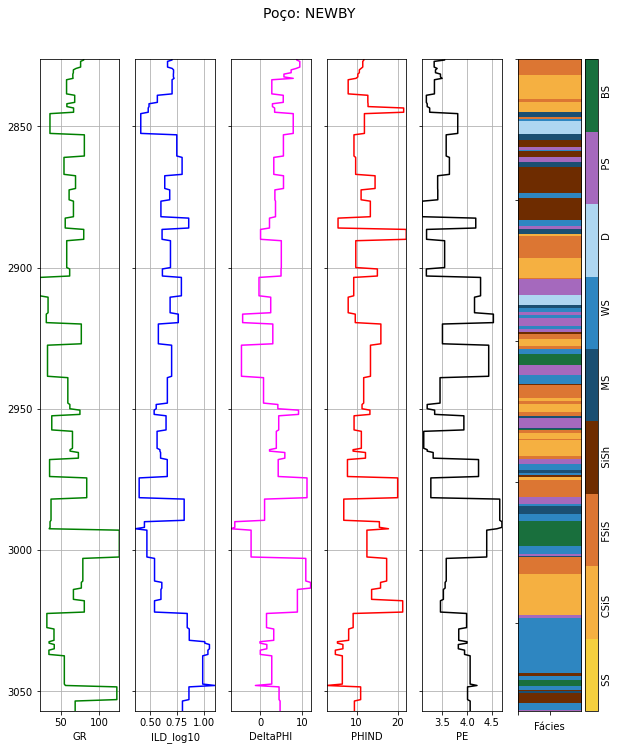

In [97]:

well_log = new_training_data[new_training_data['Well Name'] == 'SHRIMPLIN']
make_facies_log_plot(well_log, facies_colors)

well_log = new_training_data[new_training_data['Well Name'] == 'SHANKLE']
make_facies_log_plot(well_log, facies_colors)

well_log = new_training_data[new_training_data['Well Name'] == 'NEWBY']
make_facies_log_plot(well_log, facies_colors)

Observando a distribuição dos novos atributos de acordo com as fácies.

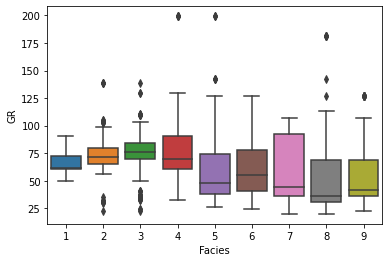

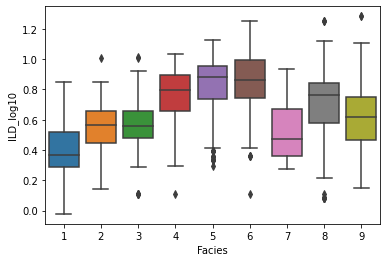

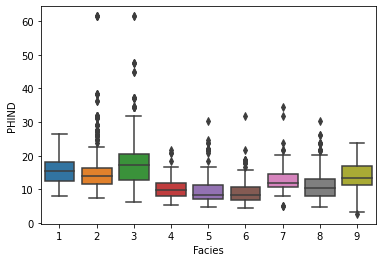

In [98]:
import seaborn as sns
well_log = new_training_data
sns.boxplot(x=well_log['Facies'], y=well_log['GR'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['ILD_log10'])
plt.show()
sns.boxplot(x=well_log['Facies'], y=well_log['PHIND'])
plt.show()

Resta saber se com isso melhoramos a performance do SVM. Vamos aplicar novamente as etapas (normalização, divisão entre treino e teste etc.)

In [99]:
new_feature_vectors = new_training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
new_feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,24.095484,0.220666,3.976911,6.050616,0.762029,0.500075,0.286792
min,19.892308,-0.022562,-13.066667,2.700000,1.466167,1.000000,0.010000
25%,49.996250,0.496700,1.210579,9.362500,3.195196,1.000000,0.273000
50%,68.845421,0.635950,3.223077,12.400000,3.581801,1.000000,0.526000
75%,79.460842,0.798308,5.523485,16.306250,4.194000,2.000000,0.767250
max,199.246250,1.283500,16.900000,61.475000,6.393556,2.000000,1.000000


In [100]:
# Normalização
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(new_feature_vectors)
scaled_features = scaler.transform(new_feature_vectors)
pd.DataFrame(scaled_features).describe()

,0,1,2,3,4,5,6
count,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03
mean,4.455320e-16,-4.930050e-16,7.970968e-16,2.335865e-16,3.549828e-16,1.556511e-15,5.989090e-17
std,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00
min,-1.919472e+00,-3.015339e+00,-4.181356e+00,-1.782444e+00,-2.964714e+00,-9.969107e-01,-1.779569e+00
25%,-6.699187e-01,-6.618217e-01,-5.907666e-01,-6.811456e-01,-6.953801e-01,-9.969107e-01,-8.623869e-01
50%,1.124722e-01,-3.068065e-02,-8.464279e-02,-1.790530e-01,-1.879649e-01,-9.969107e-01,1.992191e-02
75%,5.530968e-01,7.051945e-01,4.938876e-01,4.666423e-01,6.155395e-01,1.003099e+00,8.612539e-01
max,5.525146e+00,2.904295e+00,3.354971e+00,7.932946e+00,3.502434e+00,1.003099e+00,1.672943e+00


In [101]:
# Divisão treino e teste
from sklearn.model_selection import train_test_split

X_trainB, X_testB, y_trainB, y_testB = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.33, random_state=42)

print("Conjunto de dados: \t\tX: {}, \t\tY:{}".format(scaled_features.shape, correct_facies_labels.shape))
print("Conjunto de Treinamento: \tX_train: {}, \tY_train:{}".format(X_trainB.shape, y_trainB.shape))
print("Conjunto de Teste: \t\tX_test: {}, \tY_test:{}".format(X_testB.shape, y_testB.shape))

Conjunto de dados: 		X: (3232, 7), 		Y:(3232,)
Conjunto de Treinamento: 	X_train: (2165, 7), 	Y_train:(2165,)
Conjunto de Teste: 		X_test: (1067, 7), 	Y_test:(1067,)


In [102]:
# Aplicação do SVM
from sklearn import svm
# Classificador SVM
clf_SVM_proc = svm.SVC()
# Treinamento
clf_SVM_proc.fit(X_trainB,y_trainB)
# Predição nos conjunto de teste
predicted_labels_SVM = clf_SVM_proc.predict(X_testB)

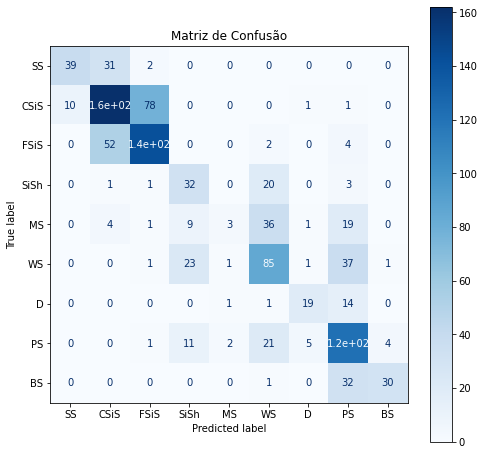

In [103]:
# Avaliação da Predição
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

conf_SVM = confusion_matrix(y_testB, predicted_labels_SVM)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_SVM, X_testB, y_testB, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, 
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [104]:
report = classification_report(y_true=y_testB,y_pred=predicted_labels_SVM)
print(report)

              precision    recall  f1-score   support

           1       0.65      0.57      0.61        72
           2       0.67      0.71      0.69       252
           3       0.70      0.68      0.69       200
           4       0.47      0.51      0.49        57
           5       0.00      0.00      0.00        73
           6       0.50      0.69      0.58       149
           7       0.59      0.37      0.46        35
           8       0.58      0.63      0.60       166
           9       0.76      0.83      0.79        63

    accuracy                           0.62      1067
   macro avg       0.55      0.55      0.55      1067
weighted avg       0.58      0.62      0.60      1067



In [105]:
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

Facies classification accuracy = 0.6166822867853796
Adjacent facies classification accuracy = 0.901593252108716


Para métrica de acurácia os resultados foram iguais para duas casas decimais. Vamos agora comparar outras duas métricas para classificadores: F-1 Score e MCC (*Matthews correlation coefficient* (MCC)) - MCC costuma ser útil para classes com tamanhos muito diferentes.


In [106]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
print('F1-score = {}'.format(f1_score(y_testB , predicted_labels_SVM, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_testB , predicted_labels_SVM)))


F1-score = 0.5965437185546125
MCC = 0.547070078188692


A performance do algoritmo piorou um pouco os resultados das métricas.

### Nesta nova tentativa, ao invés de trocarmos os perfis pelos segmentados vamos acrescentá-los na matriz.

In [38]:
#acrescentando colunas
add_training_data = training_data.copy()
add_training_data['GR_seg'] = GR_preproc
add_training_data['ILD_log10_seg'] = ILD_preproc
add_training_data['PHIND_seg'] = PHI_preproc
add_training_data['PE_seg'] = PE_preproc
add_training_data['DeltaPHI_seg'] = DPHI_preproc

In [39]:
add_feature_vectors = add_training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
# Normalização
scaler = preprocessing.StandardScaler().fit(add_feature_vectors)
scaled_features = scaler.transform(add_feature_vectors)
pd.DataFrame(scaled_features).describe()
# Divisão treino e teste - a letra C vai indicar os conjuntos com os perfis acrescentados
X_trainC, X_testC, y_trainC, y_testC = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.33, random_state=42)
# Aplicação do SVM
from sklearn import svm
# Classificador SVM
clf_SVM_add = svm.SVC()
# Treinamento
clf_SVM_add.fit(X_trainC,y_trainC)
# Predição nos conjunto de teste
predicted_labels_SVM = clf_SVM_add.predict(X_testC)


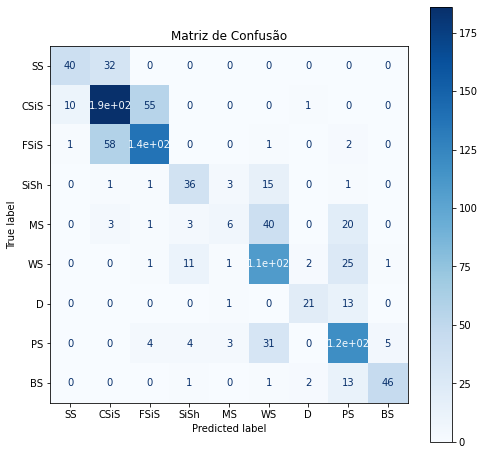

In [40]:
# Avaliação da Predição
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

conf_SVM = confusion_matrix(y_testC, predicted_labels_SVM)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_SVM_add, X_testC, y_testC, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, 
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [41]:
report = classification_report(y_true=y_testC,y_pred=predicted_labels_SVM)
print(report)

              precision    recall  f1-score   support

           1       0.78      0.56      0.65        72
           2       0.66      0.74      0.70       252
           3       0.69      0.69      0.69       200
           4       0.65      0.63      0.64        57
           5       0.43      0.08      0.14        73
           6       0.55      0.72      0.63       149
           7       0.81      0.60      0.69        35
           8       0.62      0.72      0.66       166
           9       0.88      0.73      0.80        63

    accuracy                           0.66      1067
   macro avg       0.68      0.61      0.62      1067
weighted avg       0.66      0.66      0.64      1067



In [42]:
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))
print('F1-score = {}'.format(f1_score(y_testC , predicted_labels_SVM, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_testC , predicted_labels_SVM)))

Facies classification accuracy = 0.6560449859418932
Adjacent facies classification accuracy = 0.9306466729147141
F1-score = 0.6425370887739584
MCC = 0.5923322257372968


Essa estratégia melhorou a performance do SVM, tivemos um acréscimo de cerca de 3% na maioria das métricas. Por tanto o SVM responde melhor ao acréscimo dos atributos do que a substituição dos perfis originais por eles.

## 5. Random Forest - RF

### 5.1. Treinamento do classificador RF

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=200)
clf_RF.fit(X_train,y_train)
predicted_labels_RF = clf_RF.predict(X_test)

In [44]:
# Repetindo para os perfis segmentados
clf_RFB = RandomForestClassifier(n_estimators=200)
clf_RFB.fit(X_trainB,y_trainB)
predicted_labels_RFB = clf_RFB.predict(X_testB)

In [45]:
# Repetindo para o dataset aumentado com os perfis segmentados
clf_RFC = RandomForestClassifier(n_estimators=200)
clf_RFC.fit(X_trainC,y_trainC)
predicted_labels_RFC = clf_RFC.predict(X_testC)

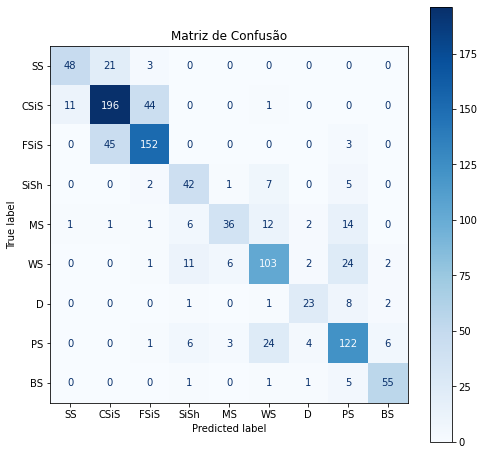

In [46]:
conf_RF = confusion_matrix(y_test, predicted_labels_RF)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_RF, X_test, y_test, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, values_format="d",
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [47]:
report = classification_report(y_true=y_test,y_pred=predicted_labels_RF)
print(report)

              precision    recall  f1-score   support

           1       0.80      0.67      0.73        72
           2       0.75      0.78      0.76       252
           3       0.75      0.76      0.75       200
           4       0.63      0.74      0.68        57
           5       0.78      0.49      0.61        73
           6       0.69      0.69      0.69       149
           7       0.72      0.66      0.69        35
           8       0.67      0.73      0.70       166
           9       0.85      0.87      0.86        63

    accuracy                           0.73      1067
   macro avg       0.74      0.71      0.72      1067
weighted avg       0.73      0.73      0.73      1067



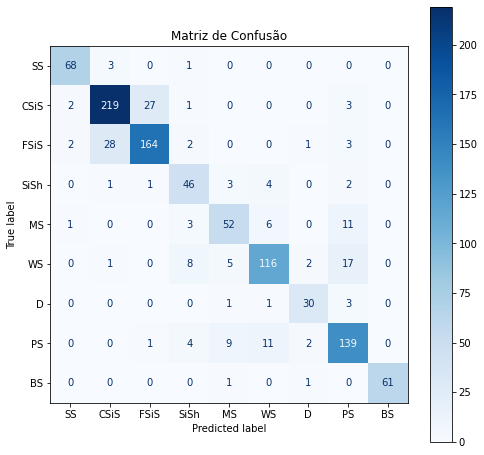

In [48]:
conf_RFB = confusion_matrix(y_testB, predicted_labels_RFB)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_RFB, X_testB, y_testB, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, values_format="d",
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [49]:
report = classification_report(y_true=y_testB,y_pred=predicted_labels_RFB)
print(report)

              precision    recall  f1-score   support

           1       0.93      0.94      0.94        72
           2       0.87      0.87      0.87       252
           3       0.85      0.82      0.83       200
           4       0.71      0.81      0.75        57
           5       0.73      0.71      0.72        73
           6       0.84      0.78      0.81       149
           7       0.83      0.86      0.85        35
           8       0.78      0.84      0.81       166
           9       1.00      0.97      0.98        63

    accuracy                           0.84      1067
   macro avg       0.84      0.84      0.84      1067
weighted avg       0.84      0.84      0.84      1067



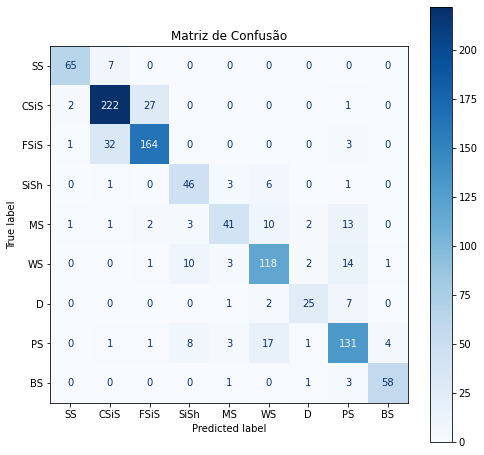

In [50]:
conf_RFC = confusion_matrix(y_testC, predicted_labels_RFC)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_RFC, X_testC, y_testC, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, values_format="d",
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [51]:
report = classification_report(y_true=y_testC,y_pred=predicted_labels_RFC)
print(report)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92        72
           2       0.84      0.88      0.86       252
           3       0.84      0.82      0.83       200
           4       0.69      0.81      0.74        57
           5       0.79      0.56      0.66        73
           6       0.77      0.79      0.78       149
           7       0.81      0.71      0.76        35
           8       0.76      0.79      0.77       166
           9       0.92      0.92      0.92        63

    accuracy                           0.82      1067
   macro avg       0.82      0.80      0.80      1067
weighted avg       0.82      0.82      0.81      1067



In [52]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")

print("SVM")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF, adjacent_facies)))
print('F1-score = {}'.format(f1_score(y_test , predicted_labels_RF, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_test , predicted_labels_RF)))

SVM
Facies classification accuracy = 0.6560449859418932
Adjacent facies classification accuracy = 0.9306466729147141

RF
Facies classification accuracy = 0.7282099343955014
Adjacent facies classification accuracy = 0.9353327085285849
F1-score = 0.7266634949244837
MCC = 0.678981807200836


In [53]:


print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RFB)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RFB, adjacent_facies)))
print('F1-score = {}'.format(f1_score(y_testB , predicted_labels_RFB, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_testB , predicted_labels_RFB)))


RF
Facies classification accuracy = 0.8388003748828491
Adjacent facies classification accuracy = 0.9456419868791003
F1-score = 0.8390969769763488
MCC = 0.8103812364554045


In [54]:
print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RFC)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RFC, adjacent_facies)))
print('F1-score = {}'.format(f1_score(y_testC , predicted_labels_RFC, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_testC , predicted_labels_RFC)))


RF
Facies classification accuracy = 0.8153701968134958
Adjacent facies classification accuracy = 0.9447047797563262
F1-score = 0.8141721488585453
MCC = 0.782236129903752


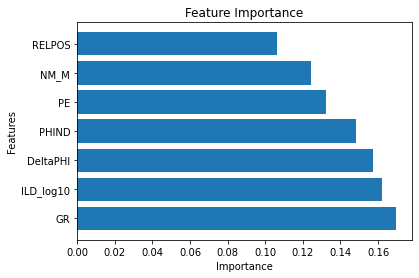

In [55]:
features_names = ["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","RELPOS"]
feature_importance = pd.Series(clf_RF.feature_importances_, index=features_names).sort_values(ascending=False)

plt.barh(features_names, feature_importance)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

Notem o aumento de importância que o GR ganha com a aplicação do algotitmo de segmentação de camadas. Isso indica que essa informação das camadas é muito importante para que árvore possa separar as litofácies.

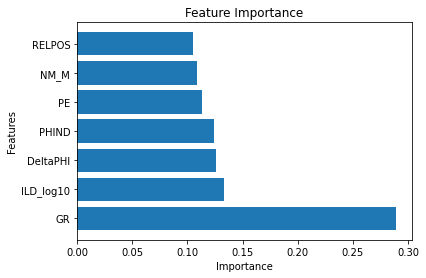

In [56]:
features_names = ["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","RELPOS"]
feature_importance = pd.Series(clf_RFB.feature_importances_, index=features_names).sort_values(ascending=False)

plt.barh(features_names, feature_importance)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

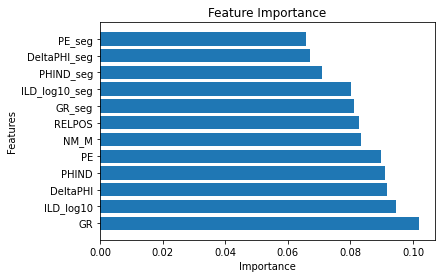

In [57]:
features_names = ["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","RELPOS", "GR_seg","ILD_log10_seg", "PHIND_seg", "DeltaPHI_seg", "PE_seg"]

feature_importance = pd.Series(clf_RFC.feature_importances_, index=features_names).sort_values(ascending=False)

plt.barh(features_names, feature_importance)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

### 5.1. Busca dos melhores parâmetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Numero de arvores (estimadores)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Numero de atributos a considerar em cada arvore
max_features = ['auto', 'sqrt']
# Maxima profundidade dos arvores
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Numero minimo de amostras para dividir um nó
min_samples_split = [2, 5, 10]
# Numero minimo de amostras em cada folha do arvore
min_samples_leaf = [1, 2, 4]
# Metodo para seleção de amostras para treinamento de cada arvore
bootstrap = [True, False]
# Random Grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Usando um random grid para a busca dos parâmetros
rf = RandomForestClassifier()
# Parâmetros do Random Search: # iterations, # folds
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)
# Treinamento
rf_random.fit(X_trainB, y_trainB)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
predicted_labels_RF_best = rf_random.best_estimator_.predict(X_testB)
conf_RF_best = confusion_matrix(y_testB, predicted_labels_RF_best)

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")

print("SVM")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF, adjacent_facies)))

print("\nRF Best")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF_best)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF_best, adjacent_facies)))

SVM
Facies classification accuracy = 0.6560449859418932
Adjacent facies classification accuracy = 0.9306466729147141

RF
Facies classification accuracy = 0.7310215557638238
Adjacent facies classification accuracy = 0.9400187441424555

RF Best
Facies classification accuracy = 0.8425492033739457
Adjacent facies classification accuracy = 0.9465791940018744


In [ ]:
print('F1-score = {}'.format(f1_score(y_testB , predicted_labels_RF_best, average = 'weighted')))
print('MCC = {}'.format(matthews_corrcoef(y_testB , predicted_labels_RF_best)))

F1-score = 0.8430531507667817
MCC = 0.814816111242231


A melhor configuração encontrada de parâmetros alcançou os mesmos resultados do Random Forest com os parâmetros default e os perfis dos atributos substituindo o original. Concluímos que a utilização do nosso método tem mais impacto do que a mudança dos parâmetros.

### 6.1. Resultados

A tabela a seguir lista os resultados alcançados por cada metodologia:

Método | Precision | Recall| F1-score | Acurácia | Acurácia Fácies Adjacentes | MCC
:---: | :---: | :---: | :--: |:---: | :---: | :---: 
SVM| 0.63 | 0.63 | 0.61 | 0.63 | 0.92 | 0.56
SVM perfis substituídos | 0.58 | 0.62 | 0.60 | 0.62 | 0.90 | 0.55
SVM atributos acrescentados | 0.66 | 0.66 | 0.64 | 0.66 | 0.93 | 0.59
RF  | 0.74 | 0.73 | 0.73 | 0.73 | 0.94 | 0.68
RF perfis substituídos | **0.84** | **0.84** | **0.84** | **0.84** | **0.95** | **0.81**
RF atributos acrescentados | 0.82 | 0.82 | 0.82 | 0.82 | **0.95** | 0.78
t-SNE + KNN (artigo) | 0.79 | 0.79 | 0.79 | - | - | -


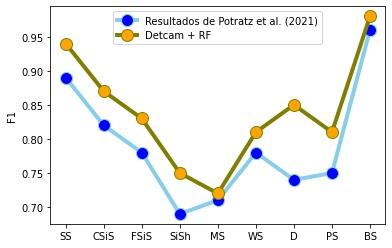

In [77]:
# Data
artigo = [.89,.82,.78,.69,.71,.78,.74,.75,.96]
detcam_rf = [.94,.87,.83,.75,.72,.81,.85,.81,.98]
df=pd.DataFrame({'x_values': facies_labels, 'Resultados de Potratz et al. (2021)': artigo, 'Detcam + RF': detcam_rf })
 
# multiple line plots
plt.plot( 'x_values', 'Resultados de Potratz et al. (2021)', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x_values', 'Detcam + RF', data=df, marker='o', markerfacecolor='orange', markersize=12, color='olive', linewidth=4)
plt.ylabel("F1")
# show legend
plt.legend()

# show graph
plt.show()



Na figura 6 do  seu artigo, Potratz et al. (2021) comparam seus resultados de F1 score para cada litofácie com os de Dubois et al. (2007), mostrando como o método t-SNE + KNN traz melhoria na performance do classificador. Aqui comparamos esse resultado com a aplicação do detector de camadas + RF e vemos que um novo avanço foi alcançado. Os resultados da aplicação direta do Random Forest apesar de muito bons, são inferiores ao do artigo, o que evidencia a contribuição que a aplicação de técnica de detecção de camadas traz para esse tipo de classificação.

### 6.2. Usando o modelo com novos dados

In [126]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


Aplicando o algoritmo detector de camadas

In [127]:
new_well_data = well_data.copy()
list_wells = new_well_data['Well Name'].unique().tolist()
GR_preproc = []
PHI_preproc = []
ILD_preproc = []
DPHI_preproc = []
PE_preproc = []
for poco in list_wells:
    well_log = new_well_data[new_well_data['Well Name'] == poco].copy()
    well_log.reset_index(inplace=True)
    GR = well_log['GR']
    ILD = well_log['ILD_log10']
    PHI = well_log['PHIND']
    PE = well_log['PE']
    DPHI = well_log['DeltaPHI']
    # Aplicando os filtros de média móvel
    mediapequena= mediamovel(GR,2)
    mediagrande = mediamovel(GR,16) # nossos testes mostraram que o melhor parâmetro aqui é 16. Sugestão testar entre 14 e 24 em outras bases
    # Gerando os perfis processados
    preproc_logs = camadas(mediapequena,mediagrande, GR, PHI, ILD, DPHI, PE)
    GR_preproc.extend(preproc_logs[0])
    PHI_preproc.extend(preproc_logs[1])
    ILD_preproc.extend(preproc_logs[2])
    DPHI_preproc.extend(preproc_logs[3])
    PE_preproc.extend(preproc_logs[4])
    # Trocando as colunas pelos perfis processados
new_well_data['GR'] = GR_preproc
new_well_data['ILD_log10'] = ILD_preproc
new_well_data['PHIND'] = PHI_preproc
new_well_data['DeltaPHI'] = DPHI_preproc
new_well_data['PE'] = PE_preproc
new_well_data


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,75.475667,0.593667,6.400000,12.066667,3.332000,1,1.000
1,A1 SH,STUART,2808.5,75.475667,0.593667,6.400000,12.066667,3.332000,1,0.978
2,A1 SH,STUART,2809.0,75.475667,0.593667,6.400000,12.066667,3.332000,1,0.956
3,A1 SH,STUART,2809.5,76.865667,0.632667,8.366667,12.616667,3.027667,1,0.933
4,A1 SH,STUART,2810.0,76.865667,0.632667,8.366667,12.616667,3.027667,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.639
826,C SH,CRAWFORD,3159.0,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.611
827,C SH,CRAWFORD,3159.5,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.583
828,C SH,CRAWFORD,3160.0,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.556


Normalização padrão

In [128]:
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
scaler = preprocessing.StandardScaler().fit(well_features)
X_unknown = scaler.transform(well_features)

Predição

In [129]:
y_unknown = clf_RF.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data



,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,2
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [130]:
new_well_features = new_well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
scaler = preprocessing.StandardScaler().fit(new_well_features)
X_unknown = scaler.transform(new_well_features)

In [131]:
new_y_unknown = clf_RFB.predict(X_unknown)
new_well_data['Facies'] = new_y_unknown
new_well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,75.475667,0.593667,6.400000,12.066667,3.332000,1,1.000,2
1,A1 SH,STUART,2808.5,75.475667,0.593667,6.400000,12.066667,3.332000,1,0.978,2
2,A1 SH,STUART,2809.0,75.475667,0.593667,6.400000,12.066667,3.332000,1,0.956,2
3,A1 SH,STUART,2809.5,76.865667,0.632667,8.366667,12.616667,3.027667,1,0.933,2
4,A1 SH,STUART,2810.0,76.865667,0.632667,8.366667,12.616667,3.027667,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.639,3
826,C SH,CRAWFORD,3159.0,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.611,3
827,C SH,CRAWFORD,3159.5,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.583,3
828,C SH,CRAWFORD,3160.0,85.759625,0.554500,5.718750,15.795000,3.220000,1,0.556,3


In [132]:
# Nomes do poços
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['STUART', 'CRAWFORD']

Visualização dos resultados

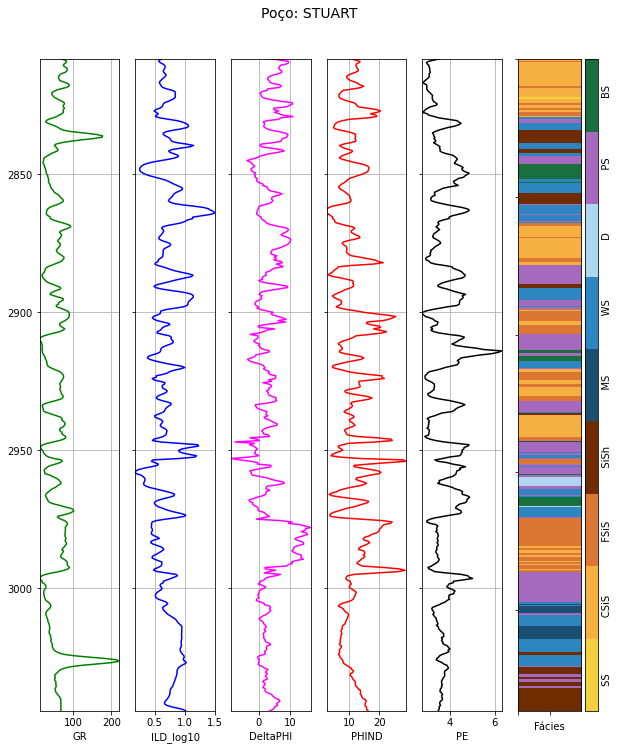

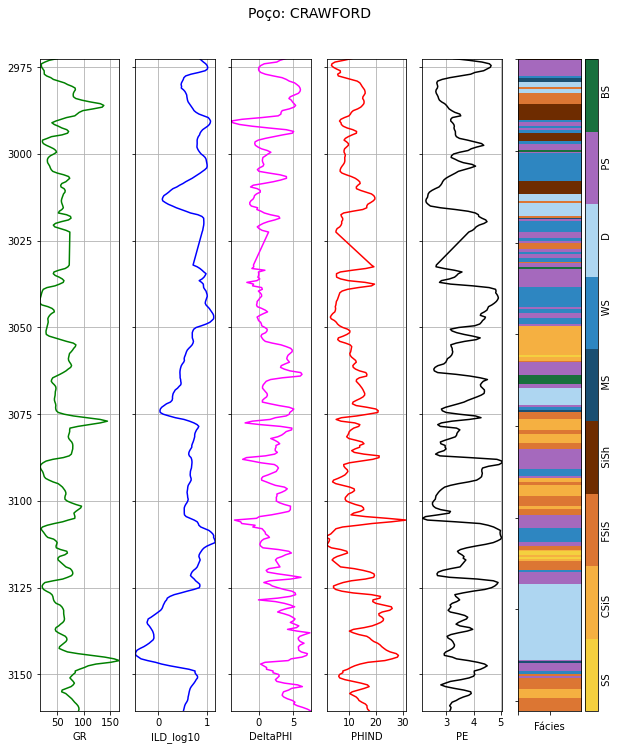

In [133]:
well_log = well_data[well_data['Well Name'] == 'STUART']
make_facies_log_plot(well_log, facies_colors)

well_log = well_data[well_data['Well Name'] == 'CRAWFORD']
make_facies_log_plot(well_log, facies_colors)

Para os perfis processados

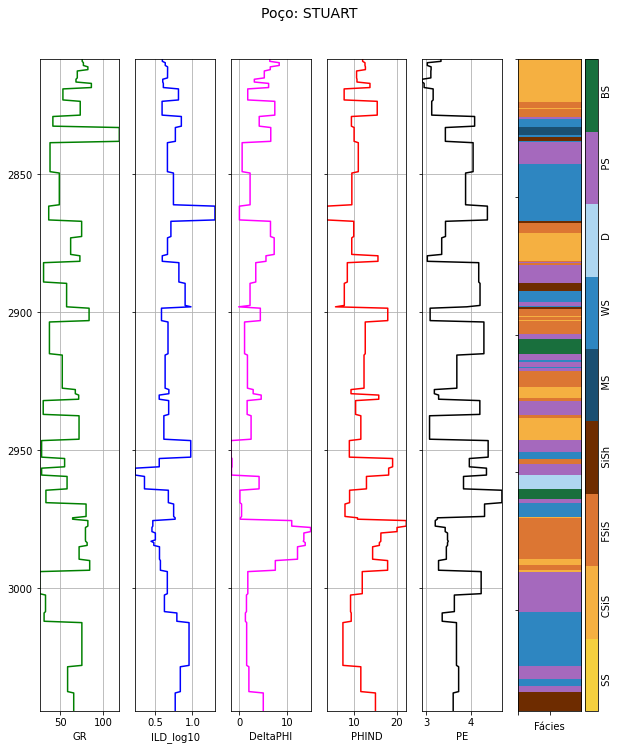

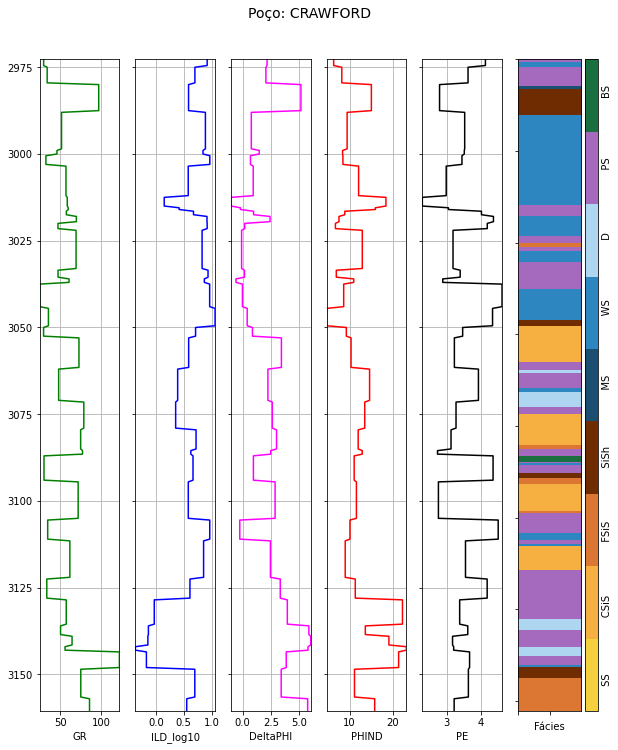

In [134]:
new_well_log = new_well_data[new_well_data['Well Name'] == 'STUART']
make_facies_log_plot(new_well_log, facies_colors)

new_well_log = new_well_data[new_well_data['Well Name'] == 'CRAWFORD']
make_facies_log_plot(new_well_log, facies_colors)


In [ ]:
well_data['Facies'] = new_y_unknown
well_log = well_data[well_data['Well Name'] == 'STUART']
make_facies_log_plot(well_log, facies_colors)

well_log = well_data[well_data['Well Name'] == 'CRAWFORD']
make_facies_log_plot(well_log, facies_colors)

### Referências Bibliográficas
REID, L.; LINSEY, T.; FROSTICK, L. E. Automatic bedding discriminator for use with digital wireline logs. **Marine and petroleum geology**, [S.I.], v.6, n.4, p.364-369, 1989.
DUBOIS, M.K.; BOHLING, G.C., CHAKRABARTI, S. Comparison of four approaches to a rock facies classification problem. **Computer & Geosciences**, 33(5); 599-617, 2007.
POTRATZ, G.L.; CANCHUMUNI, S.W.A.; CASTRO, J.D.B.; POTRATZ, J.; PACHECO, M.C.C. Automatic lithofacies classification with t-SNE and K-Nearest Neighbors Algorithm. **Anuário do Instituto de Geociências**, 44:35024, DOI 10.11137/2021_44_35024, 2021. 

